In [19]:
import numpy as np
import pylab as plt

In [20]:
import logging
logging.basicConfig(level=logging.DEBUG, format='%(message)s')

In [21]:
import torch
import swyft
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import simulators

In [23]:
DEVICE = 'cuda:0'

In [24]:
prior = simulators.prior_FermiV1
model = simulators.model_FermiV1

In [28]:
def noise(obs, params = None):
    data = {k: np.log(v + np.random.randn(*v.shape)*0) for k, v in obs.items()}
    return data

In [29]:
par0 = dict(ox=5., oy=5., a=1.5, p1=0.4, p2=1.1)
obs0 = noise(model(par0))

locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x149348f39b70>
Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x149348f39b70> on colorbar
Setting pcolormesh


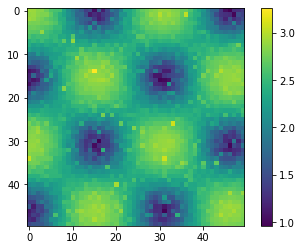

In [34]:
plt.imshow(obs0['mu'])
plt.colorbar()

In [35]:
# Convolutional network as HEAD of inference network

class Head_FermiV1(swyft.Module):
    def __init__(self, obs_shapes):
        super().__init__(obs_shapes=obs_shapes)
        
        self.n_features = 10

        self.conv1 = torch.nn.Conv2d(1, 10, 5)
        self.conv2 = torch.nn.Conv2d(10, 20, 5)
        self.conv3 = torch.nn.Conv2d(20, 40, 5)
        self.pool = torch.nn.MaxPool2d(2)
        self.l = torch.nn.Linear(160, 10)
        
    def forward(self, obs):
        x = obs['mu'].unsqueeze(1)
        nbatch = len(x)
        #x = torch.log(0.1+x)
        
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.pool(x)
        x = x.view(nbatch, -1)
        x = self.l(x)

        return x

Registering new swyft.Module with tag `Head_FermiV1`


In [36]:
s = swyft.NestedRatios(model, prior, noise = noise, obs = obs0, device = DEVICE, Ninit = 10000, Nmax=20000)

Creating new empty MemoryCache.
Creating Cache.
  params = ['ox', 'oy', 'a', 'p1', 'p2']
  obs_shapes = {'mu': (50, 50)}


Creating new cache.


In [37]:
s.run(max_rounds=1, train_args = dict(lr_schedule = [1e-3, 1e-4]), head = Head_FermiV1)

NRE round: R = 1
Number of training samples is N_R = 10000
Additional simulations are required after growing the cache.
Simulate:   0%|          | 34/9905 [00:00<00:29, 338.94it/s]

  adding 9905 new samples to simulator cache.


Simulate: 100%|██████████| 9905/9905 [00:29<00:00, 337.87it/s]
Starting neural network training.
Initializing swyft.Module with tag `Head_FermiV1`
  args = `()`
  kwargs = `{'obs_shapes': {'mu': torch.Size([50, 50])}}`
Initializing swyft.Module with tag `DefaultTail`
  args = `(10, [('ox',), ('oy',), ('a',), ('p1',), ('p2',)])`
  kwargs = `{'n_tail_features': 2, 'p': 0.0, 'hidden_layers': [256, 256, 256], 'online_norm': True, 'param_transform': None, 'tail_features': False}`
Entering trainloop
lr: 0.001
/home/weniger/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  
validation loss = nan


UnboundLocalError: local variable 'best_state_dict_head' referenced before assignment

In [ ]:
samples = s.marginals(obs0, 1000)

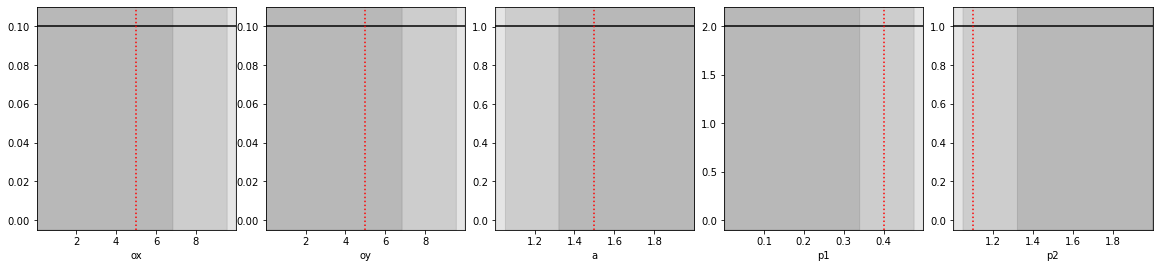

In [23]:
swyft.plot.plot1d(samples, list(prior.params()), figsize = (20, 4), ncol = 5, grid_interpolate = True, truth = par0)

In [ ]:
s2 = swyft.NestedRatios(model, prior, noise = noise, obs = obs0, device = DEVICE, Ninit = 50000, Nmax=20000)
s2.run(max_rounds=1, train_args = dict(lr_schedule = [1e-3, 1e-4]))

In [71]:
samples2 = s2.marginals(obs1, 1000)

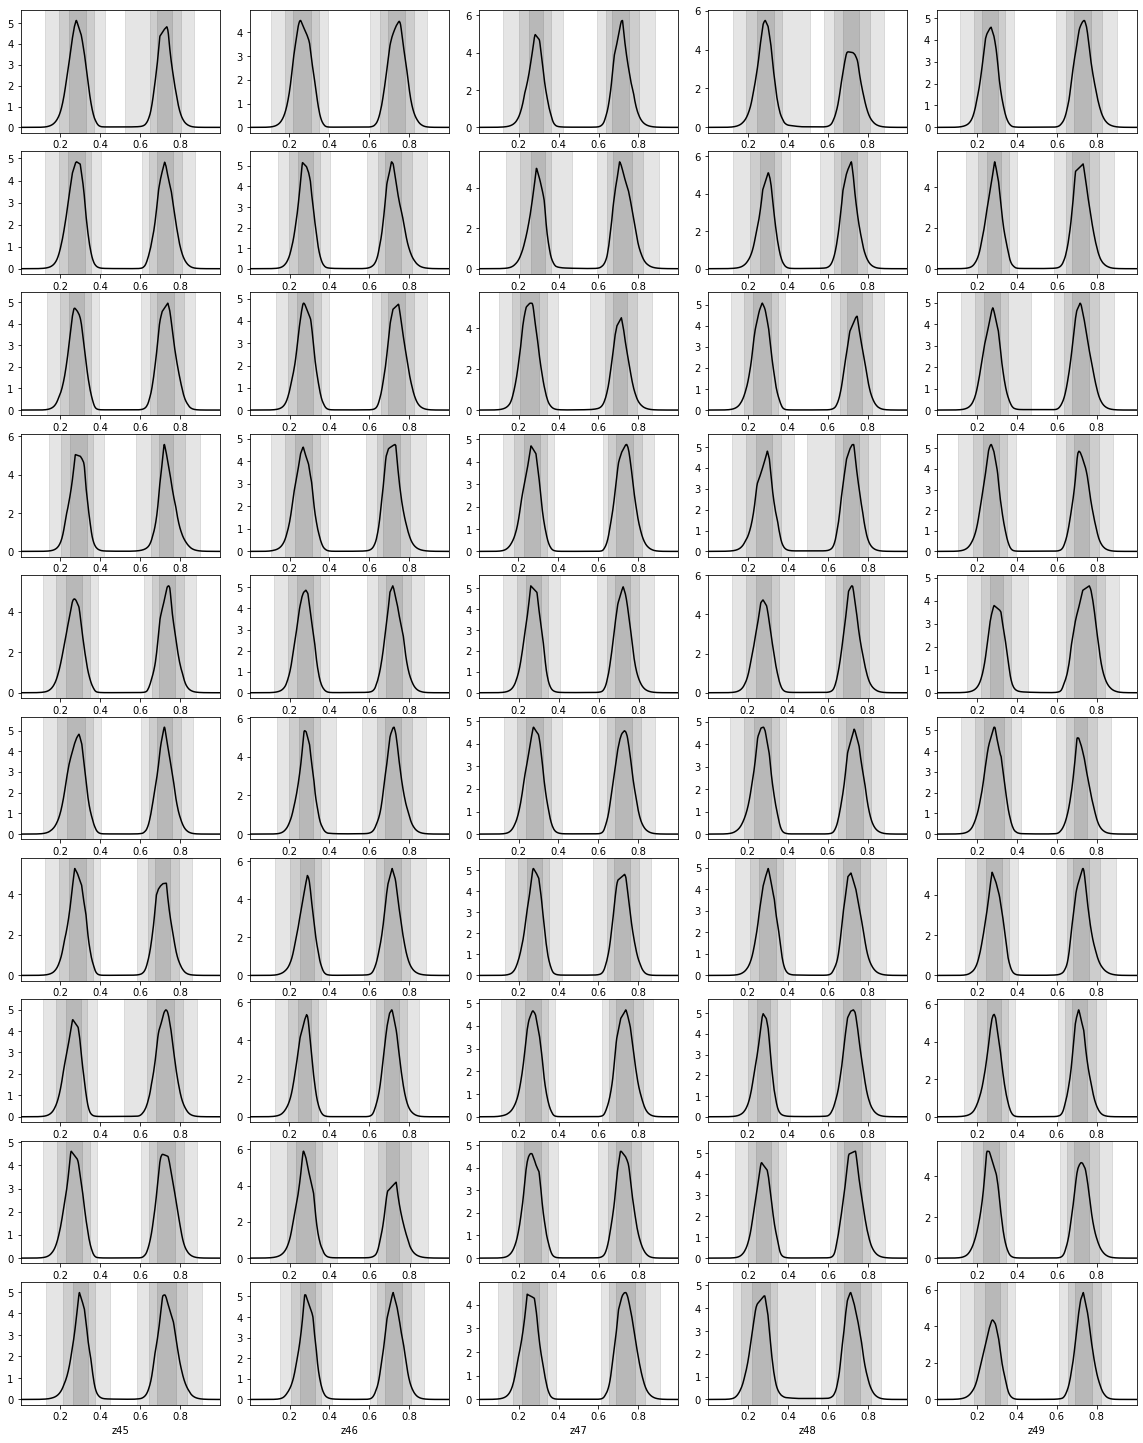

In [72]:
swyft.plot.plot1d(samples2, params, figsize = (20, 25), ncol = 5, grid_interpolate=True)

In [149]:
a = 0.25
par2 = {k: a for k in params}
obs2= model(par2)  # Asimov data

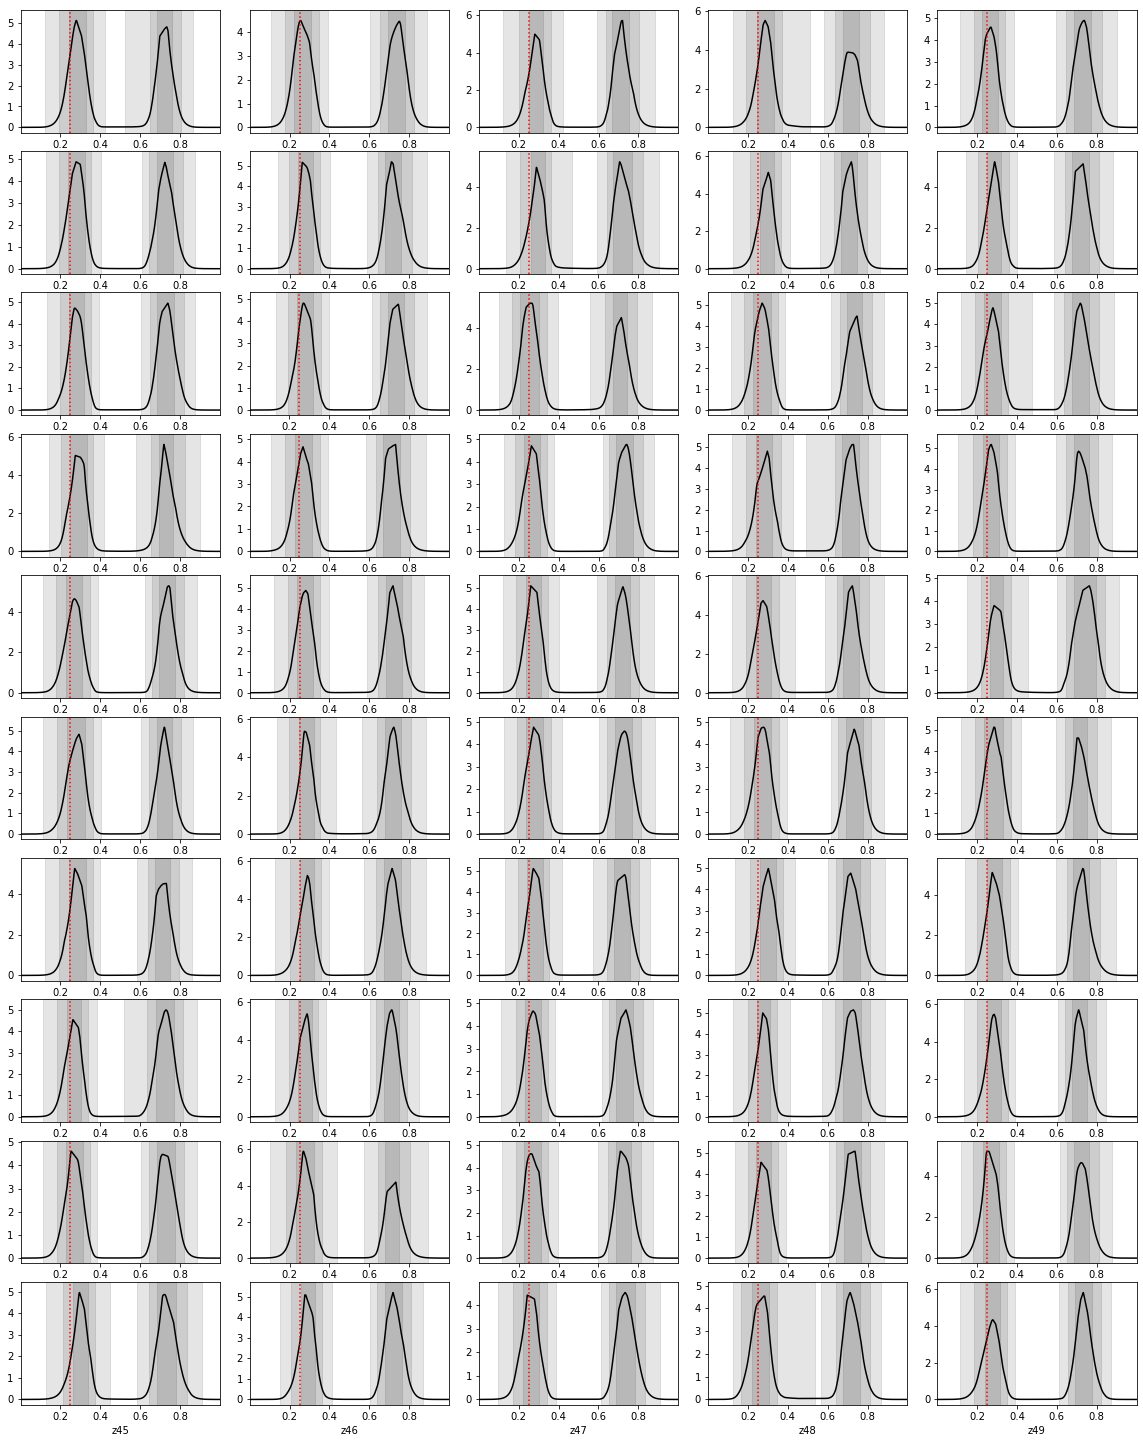

In [150]:
samples3 = s2.marginals(obs2, 3000)
swyft.plot.plot1d(samples3, params, figsize = (20, 25), ncol = 5, grid_interpolate=True, truth = par2)

In [ ]:
from scipy.stats import norm
p = lambda x: 0.5*norm.pdf(x, a, 0.05) + 0.5*norm.pdf(x, 1-a, 0.05)
true_posteriors = {(k,): p for k in params}
diag = swyft.utils.sample_diagnostics(samples3, true_posteriors = true_posteriors, true_params = par2)
plt.hist([v['KL'] for v in diag.values()], range = [0, 2.], bins = 40);